# REINFORCE algorithm for Highway Example

The algorithm is taken from here:

https://medium.com/@thechrisyoon/deriving-policy-gradients-and-implementing-reinforce-f887949bd63

First let's port it to the `gymnasium` environment, since it is still using the `gym` environment

In [18]:
import sys
import torch  
import gymnasium as gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import matplotlib
import time
from pprint import pprint

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

# Constants
GAMMA = 0.9

class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(PolicyNetwork, self).__init__()

        self.num_actions = num_actions
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.softmax(self.linear2(x), dim=1)
        return x 
    
    def get_action(self, state):
        if isinstance(state, np.ndarray):
            state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.forward(Variable(state)).cpu()
        highest_prob_action = np.random.choice(self.num_actions, p=np.squeeze(probs.detach().numpy()))
        log_prob = torch.log(probs.squeeze(0)[highest_prob_action])
        return highest_prob_action, log_prob

In [21]:
def update_policy(policy_network, rewards, log_probs):
    discounted_rewards = []

    for t in range(len(rewards)):
        Gt = 0 
        pw = 0
        for r in rewards[t:]:
            Gt = Gt + GAMMA**pw * r
            pw = pw + 1
        discounted_rewards.append(Gt)
        
    discounted_rewards = torch.tensor(discounted_rewards)
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9) # normalize discounted rewards

    policy_gradient = []
    for log_prob, Gt in zip(log_probs, discounted_rewards):
        policy_gradient.append(-log_prob * Gt)
    
    policy_network.optimizer.zero_grad()
    policy_gradient = torch.stack(policy_gradient).sum()
    policy_gradient.backward()
    policy_network.optimizer.step()

episode: 0, total reward: 19.0, average_reward: 19.0, length: 18
episode: 1, total reward: 21.0, average_reward: 20.0, length: 20
episode: 2, total reward: 11.0, average_reward: 17.0, length: 10
episode: 3, total reward: 13.0, average_reward: 16.0, length: 12
episode: 4, total reward: 26.0, average_reward: 18.0, length: 25
episode: 5, total reward: 26.0, average_reward: 19.333, length: 25
episode: 6, total reward: 11.0, average_reward: 18.143, length: 10
episode: 7, total reward: 45.0, average_reward: 21.5, length: 44
episode: 8, total reward: 12.0, average_reward: 20.444, length: 11
episode: 9, total reward: 28.0, average_reward: 21.2, length: 27
episode: 10, total reward: 16.0, average_reward: 20.9, length: 15
episode: 11, total reward: 11.0, average_reward: 19.9, length: 10
episode: 12, total reward: 17.0, average_reward: 20.5, length: 16
episode: 13, total reward: 33.0, average_reward: 22.5, length: 32
episode: 14, total reward: 17.0, average_reward: 21.6, length: 16
episode: 15, t

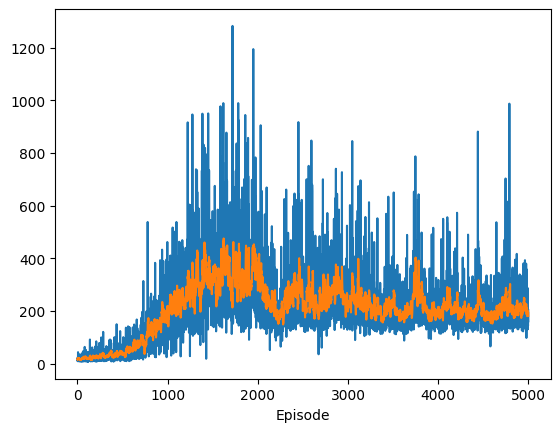

In [3]:
env = gym.make('CartPole-v1', render_mode="rgb_array")
policy_net = PolicyNetwork(env.observation_space.shape[0], env.action_space.n, 128)

max_episode_num = 5000
max_steps = 10000
numsteps = []
avg_numsteps = []
all_rewards = []

for episode in range(max_episode_num):
    state, info = env.reset()
    log_probs = []
    rewards = []

    for steps in range(max_steps):
        env.render()
        action, log_prob = policy_net.get_action(state)
        new_state, reward, done, info, _ = env.step(action)
        log_probs.append(log_prob)
        rewards.append(reward)

        if done:
            update_policy(policy_net, rewards, log_probs)
            numsteps.append(steps)
            avg_numsteps.append(np.mean(numsteps[-10:]))
            all_rewards.append(np.sum(rewards))
            if episode % 1 == 0:
                sys.stdout.write("episode: {}, total reward: {}, average_reward: {}, length: {}\n".format(episode, np.round(np.sum(rewards), decimals = 3),  np.round(np.mean(all_rewards[-10:]), decimals = 3), steps))
            break

        state = new_state

plt.plot(numsteps)
plt.plot(avg_numsteps)
plt.xlabel('Episode')
plt.show()

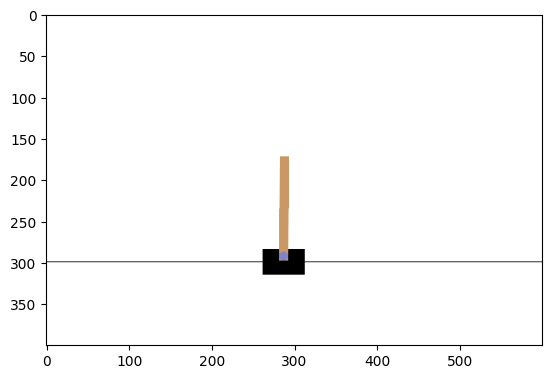

In [8]:
for i in range(100):
    action, log_prob = policy_net.get_action(state)
    next_state, reward, done, info, _ = env.step(action)
    plt.imshow(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)
    env.render()
    state = next_state
    if done:
        break
env.close()

In [63]:
env = gym.make("highway-fast-v0")
pprint(env.default_config())

state, info = env.reset()

# lets pass just 6 closest vehicles to the network and shift everything to cuda 
mask_observations = lambda o: torch.Tensor(o[:6]).flatten()

num_observations = len(mask_observations(state))

policy_net = PolicyNetwork(num_observations, env.action_space.n, 128)
# the model too
policy_net = policy_net.cuda()

max_episode_num = 2000
max_steps = 200
numsteps = []
avg_numsteps = []
all_rewards = []

/home/aai/anaconda3/envs/q-learning/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(


episode: 0, total reward: 3.548, average_reward: 3.548, length: 4
episode: 1, total reward: 11.336, average_reward: 7.442, length: 15
episode: 2, total reward: 2.615, average_reward: 5.833, length: 3
episode: 3, total reward: 4.979, average_reward: 5.62, length: 5
episode: 4, total reward: 1.885, average_reward: 4.873, length: 2
episode: 5, total reward: 1.946, average_reward: 4.385, length: 2
episode: 6, total reward: 3.399, average_reward: 4.244, length: 4
episode: 7, total reward: 6.866, average_reward: 4.572, length: 9
episode: 8, total reward: 8.902, average_reward: 5.053, length: 12
episode: 9, total reward: 5.412, average_reward: 5.089, length: 6
episode: 10, total reward: 1.118, average_reward: 4.846, length: 1
episode: 11, total reward: 3.553, average_reward: 4.068, length: 5
episode: 12, total reward: 2.32, average_reward: 4.038, length: 3
episode: 13, total reward: 4.667, average_reward: 4.007, length: 6
episode: 14, total reward: 7.531, average_reward: 4.572, length: 10
epi

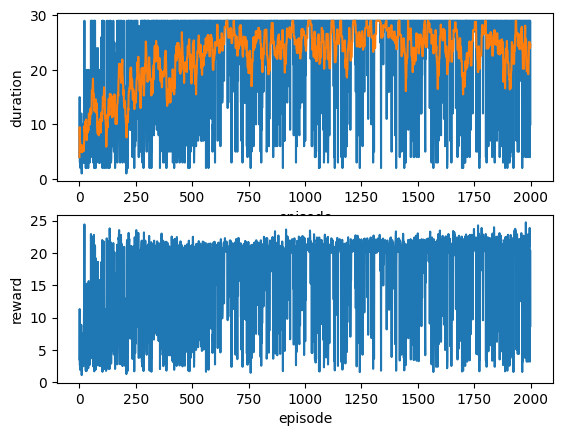

In [65]:
for episode in range(max_episode_num):
    state, info = env.reset()
    log_probs = []
    rewards = []

    for steps in range(max_steps):
        action, log_prob = policy_net.get_action(mask_observations(state).cuda().unsqueeze(0))
        new_state, reward, done, truncated, info = env.step(action)
        log_probs.append(log_prob)
        rewards.append(reward)

        # The REINFORCE algorithm learns just upon completion of a run
        if done or truncated:
            update_policy(policy_net, rewards, log_probs)
            numsteps.append(steps)
            avg_numsteps.append(np.mean(numsteps[-10:]))
            all_rewards.append(np.sum(rewards))
            if episode % 1 == 0:
                sys.stdout.write("episode: {}, total reward: {}, average_reward: {}, length: {}\n".format(episode, np.round(np.sum(rewards), decimals = 3),  np.round(np.mean(all_rewards[-10:]), decimals = 3), steps))
            break
        
        state = new_state
        
plt.subplot(2,1,1)
plt.plot(numsteps)
plt.plot(avg_numsteps)
plt.ylabel('duration')
plt.xlabel('episode')
plt.subplot(2,1,2)
plt.plot(all_rewards)
plt.ylabel('reward')
plt.xlabel('episode')

plt.show()

In [66]:
import time
for episode in range(10):
    state, meta = env.reset()
    for i in range(100):
        time.sleep(0.05)
        action, _ = policy_net.get_action(mask_observations(state).cuda().unsqueeze(0))
        next_state, reward, done, truncated, info = env.step(action)
        env.render()
        state = next_state
        if done or truncated:
            break
env.close()